# 3D (Encoder) - Encoder Decoder | Train
(can change num_frames to use in "Params" Section)

In [3]:
import sys
sys.path.append('..')
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

/Users/sizhucheng/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Collect an ensemble of box data

In [4]:
def convert_to_float(collection):
    return [x/255 for x in collection]

train_collection = get_collection("../data/data/walking/32x32/train")

total_train = sum([x.shape[0] for x in train_collection])
train_collection = convert_to_float(train_collection)
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(train_collection), total_train))

person21_walking_d3_uncomp
person22_walking_d2_uncomp
person23_walking_d3_uncomp
person21_walking_d1_uncomp
person23_walking_d4_uncomp
person24_walking_d2_uncomp
person23_walking_d1_uncomp
person21_walking_d4_uncomp
person24_walking_d1_uncomp
person23_walking_d2_uncomp
person21_walking_d2_uncomp
person24_walking_d4_uncomp
person22_walking_d3_uncomp
person22_walking_d4_uncomp
person24_walking_d3_uncomp
person22_walking_d1_uncomp

After Augmentation: img_collections has 16 collections, 11104 images in total


In [5]:
test_collection = get_collection("../data/data/walking/32x32/test")
test_collection = convert_to_float(test_collection)
total_test = sum([x.shape[0] for x in test_collection])
print("\nAfter Augmentation: Test set has {} collections, {} images in total".format(len(test_collection), total_test))

person25_walking_d1_uncomp
person25_walking_d4_uncomp
person25_walking_d3_uncomp
person25_walking_d2_uncomp

After Augmentation: Test set has 4 collections, 2484 images in total


## Sample from Collection

In [6]:
def sample(collection,batch_size = 8, gap = 1,num_frames=1):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        before_imgs, after_img, mid_imgs -  [batch size, 32, 32]
    """
    assert gap%2==1, "Gap must be odd !"      
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(num_per_collection[i] - gap - (2*num_frames-1)), avg_num_per_class, replace=False)
            before_ind.append(s)
        except: # if not enough in this class
            before_ind.append(np.array([]))
    #all before-index
    all_before=[[x+i for x in before_ind] for i in range(num_frames)]
    #all after-index
    all_after=[[x+gap+i+1 for x in before_ind] for i in range(num_frames)]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classes = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = [np.concatenate([collection[i][all_before[j][i]] for i in selected_classes], axis = 0)for j in range(num_frames)]
    #before2_imgs = np.concatenate([collection[i][before2_ind[i]] for i in selected_classes], axis = 0)
    after_imgs = [np.concatenate([collection[i][all_after[j][i]] for i in selected_classes], axis = 0)for j in range(num_frames)]
    #after2_imgs = np.concatenate([collection[i][after2_ind[i]] for i in selected_classes], axis = 0)
    mid_imgs = np.concatenate([collection[i][mid_ind[i]] for i in selected_classes], axis = 0)
    
    before_imgs = [before_imgs[j][:batch_size] for j in range(num_frames)]
    #before2_imgs = before2_imgs[:batch_size]
    mid_imgs = mid_imgs[:batch_size]
    after_imgs = [after_imgs[j][:batch_size] for j in range(num_frames)]
    #after2_imgs = after2_imgs[:batch_size]
    return before_imgs, after_imgs,mid_imgs


def sample_train(batch_size = 8, gap = 3,num_frames=1): return sample(train_collection,batch_size, gap = gap,num_frames=1)

def sample_test(batch_size = 8, gap = 3,num_frames=1):  return sample(test_collection,batch_size, gap,num_frames)

## Take a look at Training data

Range of Image Piece Value: [0.08627450980392157, 1.0]
Before (1st frame): (8, 32, 32)
After (1st frame):  (8, 32, 32)
Mid:    (8, 32, 32)


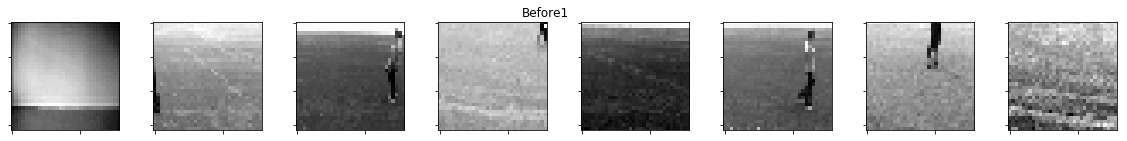

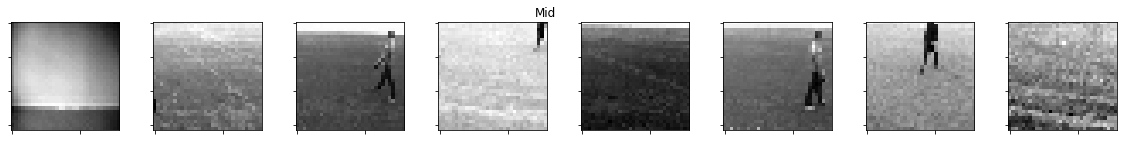

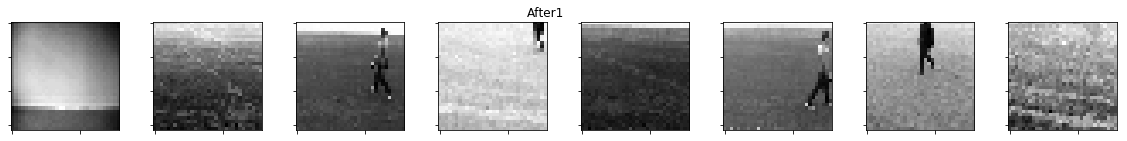

In [7]:
def show_sample_train(batch_size, gap,num_frames=1):
    before, after, mid = sample_train(batch_size=batch_size, gap=gap, num_frames=num_frames)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before (1st frame): {}".format(before[0].shape))
    print("After (1st frame):  {}".format(after[0].shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before[0], size, "Before1")
    plot_images(mid, size, "Mid")
    plot_images(after[0], size, "After1")
    
show_sample_train(batch_size = 8, gap = 9,num_frames=3)

## Sample of Test Data

Range of Image Piece Value: [0.08235294117647059, 0.7294117647058823]
Before (1st frame): (8, 32, 32)
After (1st frame):  (8, 32, 32)
Mid:    (8, 32, 32)


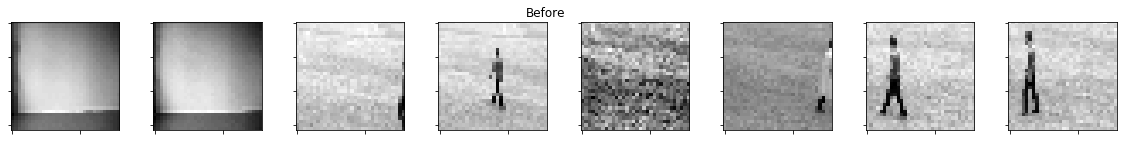

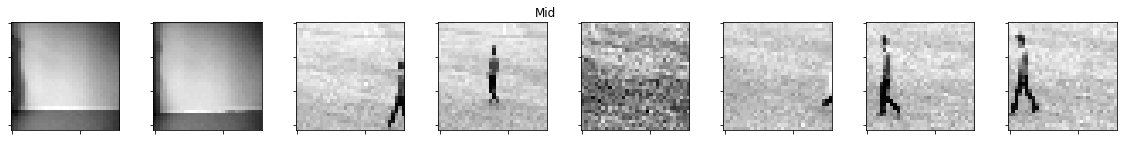

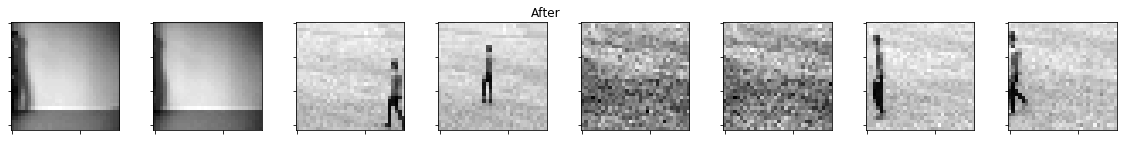

In [8]:
def show_sample_test(batch_size, gap,num_frames=3):
    before,after,mid = sample_test(batch_size=batch_size, gap=gap,num_frames=num_frames)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before (1st frame): {}".format(before[0].shape))
    print("After (1st frame):  {}".format(after[0].shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before[0], size, "Before")
    plot_images(mid, size, "Mid")
    plot_images(after[0], size, "After")

show_sample_test(batch_size=8, gap = 9,num_frames=3)

## Target

### Gap: How harsh do you want to train the model?

In [9]:
gap = 1

### Model Capacity

In [10]:
feature_channel = 256

## Param

In [11]:
batch_size = 32

learning_rate = 4e-5

beta = 0.6 # defalut 0.9 for adam
num_iteration = 5000
model_save_path = "../trained_model/box-32x32/{}/walking".format(time())
num_frames=2

In [12]:
try:
    os.mkdir(model_save_path)
    print("Model to be saved at {}".format(model_save_path))
except:
    assert "Cannot create save folder!"

### Leaky Relu

In [13]:
def leaky_relu(x): return tf.maximum(x, alpha * x)

# Encoder

In [14]:
def encode(img_list,is_training=True):
    """
    Input:
        list of batch size of img
    Output:
        batch size of feature [batch_size, 8, 8, feature_channel]
    """
    img=tf.stack(img_list)
    num_frames=len(img_list)
    x = tf.reshape(img, [-1, 32, 32,num_frames,1])
    x = tf.layers.conv3d(x, filters = 16, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv3d(x, filters = 64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)

    #x = tf.layers.conv2d(x, filters = 64, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)

    #x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv3d(x, filters = feature_channel, kernel_size=2, padding='same', activation=tf.nn.relu)
    return x

# Decoder

In [15]:
def decode(feature1, feature2, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 8, 8, feature_channel]
    Output:
        batch size of img [batch_size, 32, 32, 1]
    """
    
    x = tf.concat([feature1, feature2], axis=4)

    x = tf.reshape(x, [tf.shape(x)[0], 8, 8,512])

    x = tf.layers.conv2d(x, filters = 128, kernel_size=5, padding='same', activation=tf.nn.relu)
    x = tf.convert_to_tensor(x)
    
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3,  strides=2, activation=tf.nn.tanh, padding='same')
    #x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    return img

## Generator

In [16]:
def generate(before_list,after_list,is_training=True):
    with tf.variable_scope("generator") as scope:
        feature1, feature2 = encode(before_list,is_training), encode(after_list,is_training)
        img = decode(feature1, feature2, is_training)
        return img

### Loss

In [17]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)
    #return tf.norm(x-gd,ord=1)

### Get a Batch Generation

In [18]:
def create_dicnomid(before_list, after_list, trainornot=False):
    dic = {i1:d1 for i1,d1 in zip(batch_beforelist, before_list)}
    dic2= {i2:d2 for i2, d2 in zip(batch_afterlist,after_list)}
    dic3={is_training: trainornot}
    dic.update(dic2)
    dic.update(dic3)
    return dic

In [19]:
def create_dic(before_list, after_list,mid, trainingornot=False):
    dic = {i1:d1 for i1,d1 in zip(batch_beforelist, before_list)}
    dic2= {i2:d2 for i2, d2 in zip(batch_afterlist,after_list)}
    dic3={batch_mid: mid, is_training: trainingornot}
    dic.update(dic2)
    dic.update(dic3)
    return dic

In [20]:
def get_generation(before_list, after_list,mid):
    dic=create_dic(before_list,after_list,mid)
    gen_batch = sess.run(G_batch, dic)
    return gen_batch

### Solver

In [21]:
def get_solver(learning_rate=1e-3, beta1=0.5):
    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

### Report Loss = loss_computed * 255 / batch_size

In [22]:
def report_loss(name, num_run = 100, gap = 3, batch_size = batch_size,num_frames=num_frames):
    losses = []
    for _ in range(num_run):
        if name == "train": before,after,mid = sample_train(batch_size, gap,num_frames)
        elif name == "val": before, after, mid = sample_dev(batch_size, gap,num_frames)
        else:                before, after, mid = sample_test(batch_size, gap,num_frames)
        dic=create_dic(before,after,mid)
        loss = sess.run(G_loss, \
                        feed_dict = dic)
        losses.append(loss)
    return scale_loss(np.mean(losses) / batch_size, 2)

## Computational Graph

In [23]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32], "batch_mid")
batch_beforelist     = [tf.placeholder(tf.float32, [None, 32, 32], "batch_before1")]
batch_afterlist      = [tf.placeholder(tf.float32, [None, 32, 32], "batch_after1")]
#batch_after2      = tf.placeholder(tf.float32, [None, 32, 32], "batch_after2")
is_training      = tf.placeholder(tf.bool, (), name =  "is_training")

# alpha   = tf.Variable(0., "alpha") # parameter for leaky relu
G_batch = generate(batch_beforelist,batch_afterlist)

G_loss = content_loss(G_batch, batch_mid)
G_solver = get_solver(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

tf.add_to_collection('G_batch', G_batch)
tf.add_to_collection('loss', G_loss)

In [ ]:
def train(sess, G_step, G_loss, batch_size, num_frames, num_iteration, plot_every = 400, show_loss_every=400, nPlot=6, num_plot = 6):
    g_losses = []
    saver = tf.train.Saver()
    for i in range(num_iteration):
        # get a sample
        gap = np.random.choice(range(2*num_frames-1,2*num_frames+7,2)) #if sample two images, the lowest gap is 3, not 1
        real_beforelist,real_afterlist, real_mid = sample_train(batch_size, gap,num_frames)
        dic=create_dic(real_beforelist, real_afterlist,real_mid, trainingornot=True)
        #dic = {batch_mid: real_mid, batch_before1: real_before1,batch_before2: real_before2,\
               #batch_after1: real_after1, batch_after2: real_after2, is_training: True}
        
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        G_loss_curr = scale_loss(G_loss_curr/batch_size, 2)# tweek loss to match report loss
        
        g_losses.append(G_loss_curr)
    
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {} | Gap = {}".format(i, G_loss_curr, gap))
            
        if i%plot_every == 0:
            real_beforelist,real_afterlist,real_mid = sample_train(num_plot, gap,num_frames)
            dic2=create_dicnomid(real_beforelist, real_afterlist,trainornot=False)
            gen_batch_test = sess.run(G_batch, feed_dict=dic2)
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {} | gap = {}".format(i + plot_every, gap))
    saver.save(sess, model_save_path, global_step = i)         
    return g_losses

# Train !

Iteration 0:  G_loss = 364.97716426849365 | Gap = 5


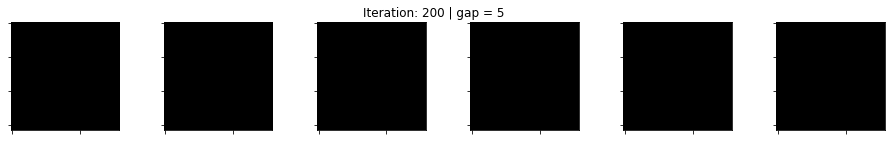

In [ ]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_frames, num_iteration, plot_every = 200, show_loss_every = 100, num_plot=6)

## Plot Learning Curve

In [ ]:
figsize = (20, 8)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(g_loss[-1000:])
plt.title("Generator Losses - Last 1000", fontsize=16)
plt.show()

# Evaluate !

In [ ]:
def show_generations(name, num = 6, gap = 3,num_frames=1):
    if name == "train":  before, after, mid = sample_train(num, gap,num_frames)
    else:                before, after, mid = sample_test(num, gap,num_frames) 
    
    gen_batch = get_generation(before,after, mid)
    size = (20, 2)
    plot_images(before[0], size, "Before")
    plot_images(after[0], size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

## - Evaluate on Training Data

In [ ]:
def eval_train(num_show = 8, gap = 3):
    show_generations("train", num_show, gap)
    loss = report_loss("train", 100, gap, batch_size)
    print("Training Loss = {}".format(loss))
    return loss

train_loss = eval_train(num_show = 8, gap = gap)

## - Evaluate on Test Data

In [ ]:
def eval_test(num_show = 6, gap = 3, num_test = 100, batch_size = batch_size):
    show_generations("test", num_show, gap)
    loss = report_loss("test", num_test, gap, batch_size)
    print("Test Loss = {}".format(loss))
    return loss

#test_collection = get_collection(".../data/walking/test")
#test_collection = augment_reverse_color(test_collection)
#test_collection = center_collections(test_collection)
test_loss = eval_test(num_show = 8, gap=1, batch_size = 8)

## How much overfitting?

In [ ]:
print("(Test Loss - Train Loss)/Train Loss = {}".format((test_loss-train_loss)/train_loss))